In [ ]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt


In [ ]:
# Step 2: Upload your CSV
from google.colab import files
uploaded = files.upload()

# Replace the filename below with your uploaded file's exact name
df = pd.read_csv("house_price_cleaned .csv")
df.head()


Saving house_price_cleaned .csv to house_price_cleaned .csv


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,zipcode
0,1,126958.0,2.0,3.000000,4933,6222,2,0,3,Fair,98103
1,2,676155.0,2.0,3.000000,4277,6315,1,0,1,Poor,98103
2,3,136932.0,4.0,2.021053,3369,5869,1,0,3,Good,98102
3,4,370838.0,4.0,1.000000,3734,1876,1,1,3,Poor,98104
4,5,264178.0,1.0,1.000000,4291,8027,2,0,3,Poor,98104


In [12]:
# Step 3: Check dataset shape and missing values
print("Shape:", df.shape)
print(df.isnull().sum())

# Identify the price column
price_col = "price"  # Change if your column has a different name

# Create a binary target: Above Median Price (1 = expensive)
df['AboveMedianPrice'] = (df[price_col] > df[price_col].median()).astype(int)

# Drop target and price from features
X = df.drop(columns=[price_col, 'AboveMedianPrice'])
y = df['AboveMedianPrice']

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


Shape: (100, 12)
id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
zipcode             0
AboveMedianPrice    0
dtype: int64


In [14]:
# Numeric transformer: fill missing with median, scale features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer: fill missing with most_frequent, one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (80, 10)
Test shape: (20, 10)


In [16]:
# Logistic Regression model
log_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
log_model.fit(X_train, y_train)

# Random Forest model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'bedrooms',
                                                   'bathrooms', 'sqft_living',
                                                   'sqft_lot', 'floors',
                                                   'waterfront', 'view',
                                                   'zipcode']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['condition'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [17]:
# 🚀 Train and evaluate both models together (safe version)

# Logistic Regression model
log_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
log_model.fit(X_train, y_train)

# Random Forest model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)

# Evaluation function
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"\n{name} Results:")
    print("------------------------")
    print(f"Accuracy : {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall   : {rec:.2f}")
    print(f"F1 Score : {f1:.2f}")
    print(f"ROC AUC  : {roc:.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return acc, roc

# ✅ Run evaluation
log_acc, log_roc = evaluate_model(log_model, X_test, y_test, "Logistic Regression")
rf_acc, rf_roc = evaluate_model(rf_model, X_test, y_test, "Random Forest")



Logistic Regression Results:
------------------------
Accuracy : 0.35
Precision: 0.33
Recall   : 0.30
F1 Score : 0.32
ROC AUC  : 0.39
Confusion Matrix:
[[4 6]
 [7 3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        10
           1       0.33      0.30      0.32        10

    accuracy                           0.35        20
   macro avg       0.35      0.35      0.35        20
weighted avg       0.35      0.35      0.35        20


Random Forest Results:
------------------------
Accuracy : 0.55
Precision: 0.55
Recall   : 0.60
F1 Score : 0.57
ROC AUC  : 0.53
Confusion Matrix:
[[5 5]
 [4 6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55

In [18]:
# Comparison Table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [log_acc, rf_acc],
    'ROC AUC': [log_roc, rf_roc]
})
print("\nModel Comparison:")
display(results)



Model Comparison:


,Model,Accuracy,ROC AUC
0,Logistic Regression,0.35,0.39
1,Random Forest,0.55,0.53


from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['ROC AUC'].plot(kind='hist', bins=20, title='ROC AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_18.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='Accuracy', y='ROC AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ROC AUC']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ROC AUC'}, axis=1)
              .sort_values('ROC AUC', ascending=True))
  xs = counted['ROC AUC']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('ROC AUC', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ROC AUC')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_24['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['ROC AUC'].plot(kind='line', figsize=(8, 4), title='ROC AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='ROC AUC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

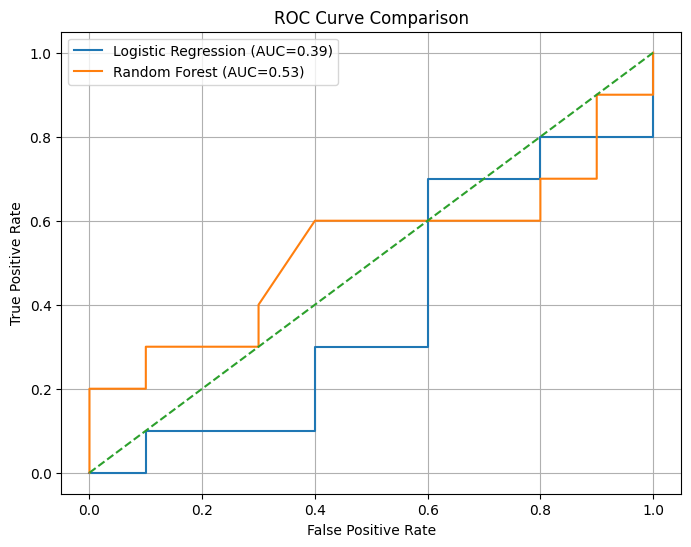

In [19]:
from sklearn.metrics import roc_curve, auc

y_proba_log = log_model.predict_proba(X_test)[:,1]
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC={auc(fpr_log,tpr_log):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc(fpr_rf,tpr_rf):.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
if rf_acc > log_acc:
    print("🌟 Random Forest performs better on this dataset.")
else:
    print("🌟 Logistic Regression performs better on this dataset.")

print("\n✅ Milestone Achieved: Built baseline classification model successfully!")


🌟 Random Forest performs better on this dataset.

✅ Milestone Achieved: Built baseline classification model successfully!
